# IID `FedAvg` Exploration

In [1]:
import numpy as np
from numpy.random import normal
import pandas as pd
from copy import deepcopy as copy

import seaborn as sns
sns.set(color_codes=True)
from sklearn.decomposition import KernelPCA, PCA

from matplotlib import pyplot as plt

import torch 
from torch import nn, optim
import pandas as pd

from sklearn.manifold import Isomap

# Data

In [2]:
from sklearn.datasets import make_blobs

n_features = 2
n_hidden = 4
n_labels = 5
n_samples = 10000

X, Y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_labels, cluster_std=0.5)
X, Y = torch.tensor(X).float(), torch.tensor(Y)

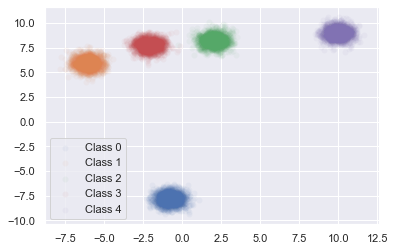

In [3]:
for i in range(n_labels):
    idx = Y == i
    sns.scatterplot(X[idx,0], X[idx,1], label='Class {}'.format(i), linewidth=0, alpha=0.05)
plt.legend()
plt.show()

# Model

In [4]:
class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(n_features, n_hidden, bias=True)
        self.tanh = nn.Tanh()
        self.fc_2 = nn.Linear(n_hidden, n_labels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        output = self.fc_1(x)
        output = self.tanh(output)
        output = self.fc_2(output)
        output = self.softmax(output)
        
        return output
    
    """
        Utility functions to take average of models
    """
    
    def __add__(self, other):
        my_copy = copy(self)
        with torch.no_grad():
            for self_param, other_param in zip(my_copy.parameters(), other.parameters()):
                self_param.data += other_param.data
        return my_copy
    
    def __truediv__(self, n):
        my_copy = copy(self)
        with torch.no_grad():
            for self_param in my_copy.parameters():
                self_param.data /= n
        return my_copy
    
    def zero(self):
        for self_param in self.parameters():
            self_param.data = torch.zeros_like(self_param.data)
        return self

In [5]:
n_model_params = sum([param.reshape(-1).shape[0] for param in MLP().parameters()])

In [6]:
MLP()

MLP(
  (fc_1): Linear(in_features=2, out_features=4, bias=True)
  (tanh): Tanh()
  (fc_2): Linear(in_features=4, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

# Centalized Benchmark

In [102]:
loss_fn = nn.NLLLoss()
batch_size = 200
n_steps = 500
n_runs = 20

In [103]:
all_steps = [[[] for _ in range(n_steps)] for _ in range(n_runs)]
losses = [[] for _ in range(n_runs)]
acc = [[] for _ in range(n_runs)]

final_models = []

for run in range(n_runs):
    model = MLP()
    optimizer = optim.Adam(lr=0.01, params=model.parameters())
    for step in range(n_steps):
        # log model state
        for name, param in model.named_parameters():
            all_steps[run][step].extend(list(param.view(-1).detach().numpy()))
        # take a step of SGD
        optimizer.zero_grad()
        batch_idx = np.random.randint(0, n_samples, batch_size)
        predict = model(X[batch_idx])
        loss = loss_fn(predict, Y[batch_idx])
        loss.backward()
        optimizer.step()
        losses[run].append(loss.item())
        acc[run].append(sum(torch.argmax(predict, dim=1) == Y[batch_idx]))
    final_models.append(model)

## Progression of Training

In [104]:
step_matrix = torch.tensor(all_steps).reshape(-1, n_model_params)

In [105]:
pca = KernelPCA(n_components=2,kernel='rbf')

x = pca.fit_transform(step_matrix)

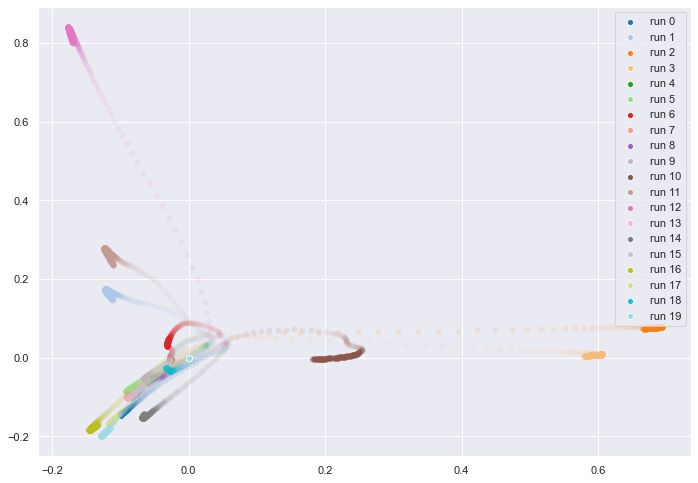

In [106]:
for i, color in zip(range(n_runs), plt.get_cmap('tab20').colors[:n_runs]):
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.scatterplot(x[i*n_steps:(i+1)*n_steps,0], x[i*n_steps:(i+1)*n_steps,1],alpha=0.1,color=color, linewidth=0)
    sns.scatterplot([0],[0],label="run {}".format(i), color=color)
plt.legend()
plt.show()

In [107]:
runs = pd.DataFrame(columns = ['run', 'step', 'loss', 'accuracy'])
runs['run'] = [i for i in range(n_runs) for _ in range(n_steps)]
runs['step'] = list(range(n_steps)) * n_runs
runs['loss'] = np.array(losses).reshape(-1)
runs['accuracy'] = np.array(acc).reshape(-1) / batch_size * 100

## Loss

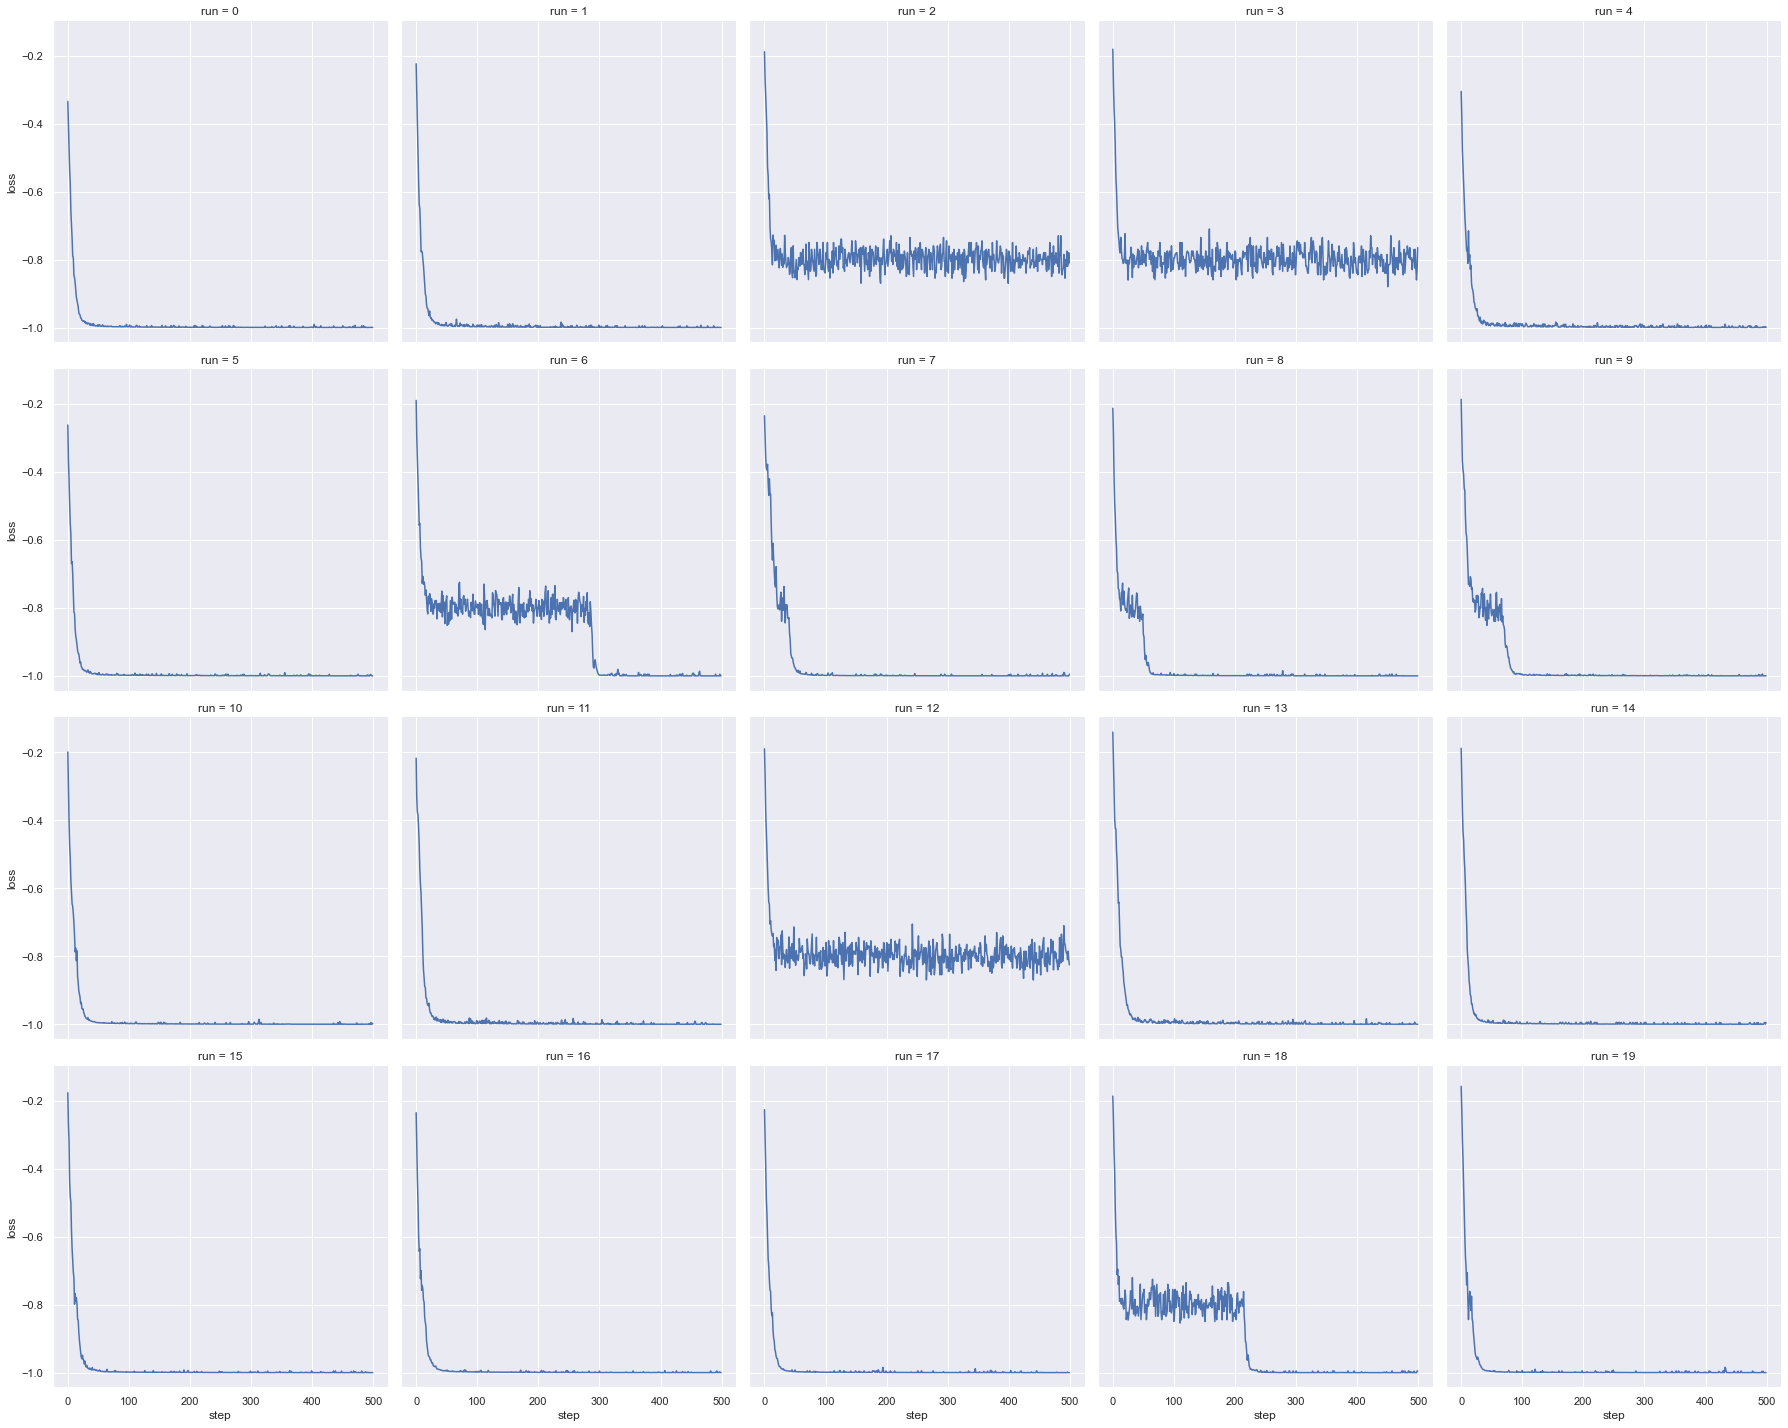

In [108]:
sns.relplot(x="step", y="loss", col="run", kind="line", data=runs, col_wrap=5)

## Accuracy

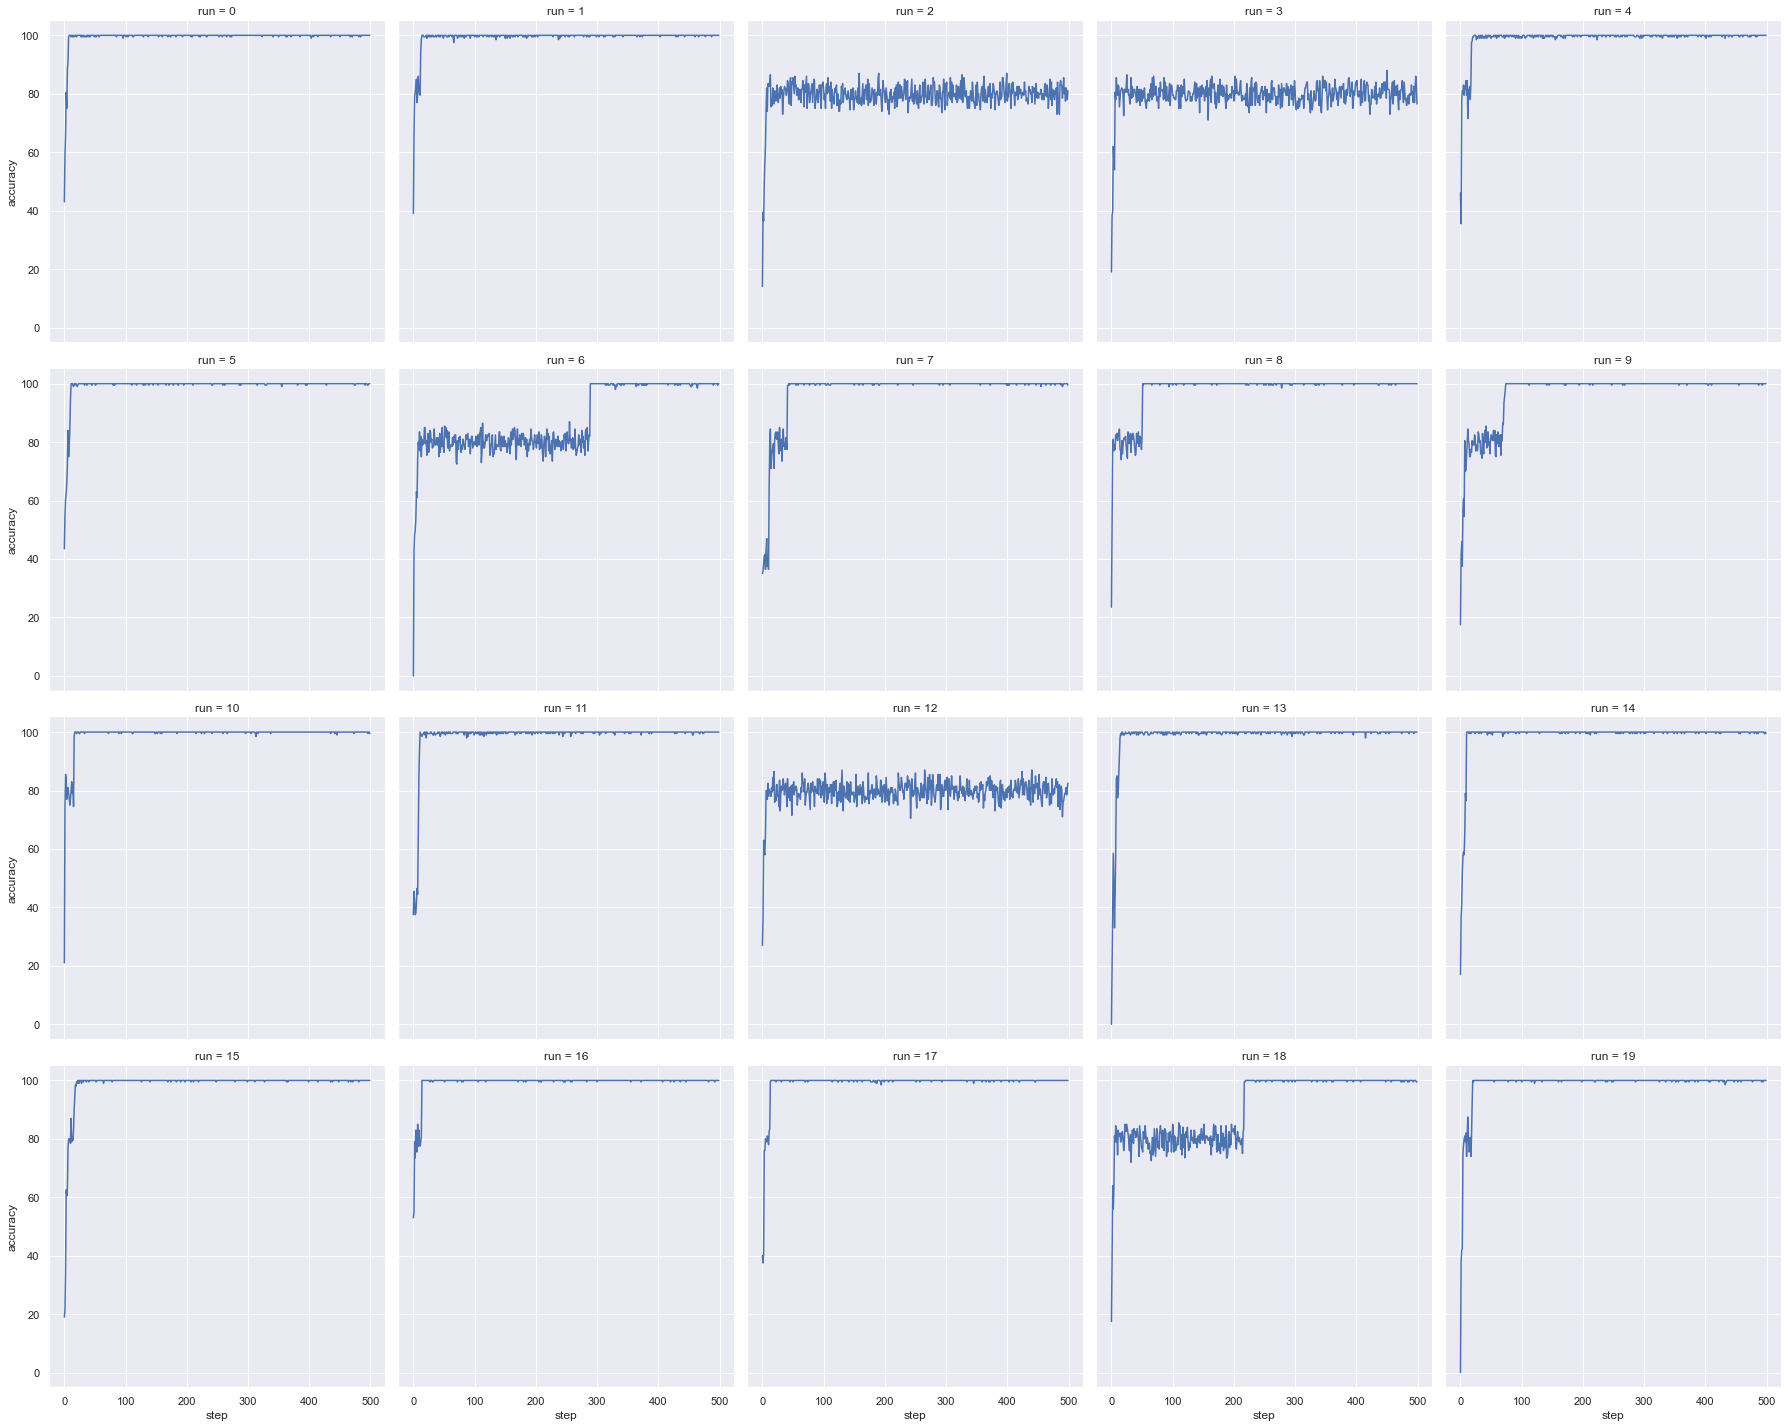

In [109]:
sns.relplot(x="step", y="accuracy", col="run", kind="line", data=runs, col_wrap=5)

## Classification Boundry

In [85]:
model_predictions = pd.DataFrame(columns = ['model','feature_1', 'feature_2', 'label'])
X_test = torch.tensor(np.mgrid[-12.5:6:0.05, -12.5:8:0.05].T.reshape(-1,2)).float()
points = X_test.shape[0]

model_predictions['model'] = [i for i in range(n_runs) for _ in range(points)]
model_predictions['feature_1'] = list(X_test[:,0].numpy()) * n_runs
model_predictions['feature_2'] = list(X_test[:,1].numpy()) * n_runs

predictions = []
for model in final_models:
    predictions.extend(list(torch.argmax(model(X_test),dim=1).detach().numpy()))
    
model_predictions['label'] = predictions

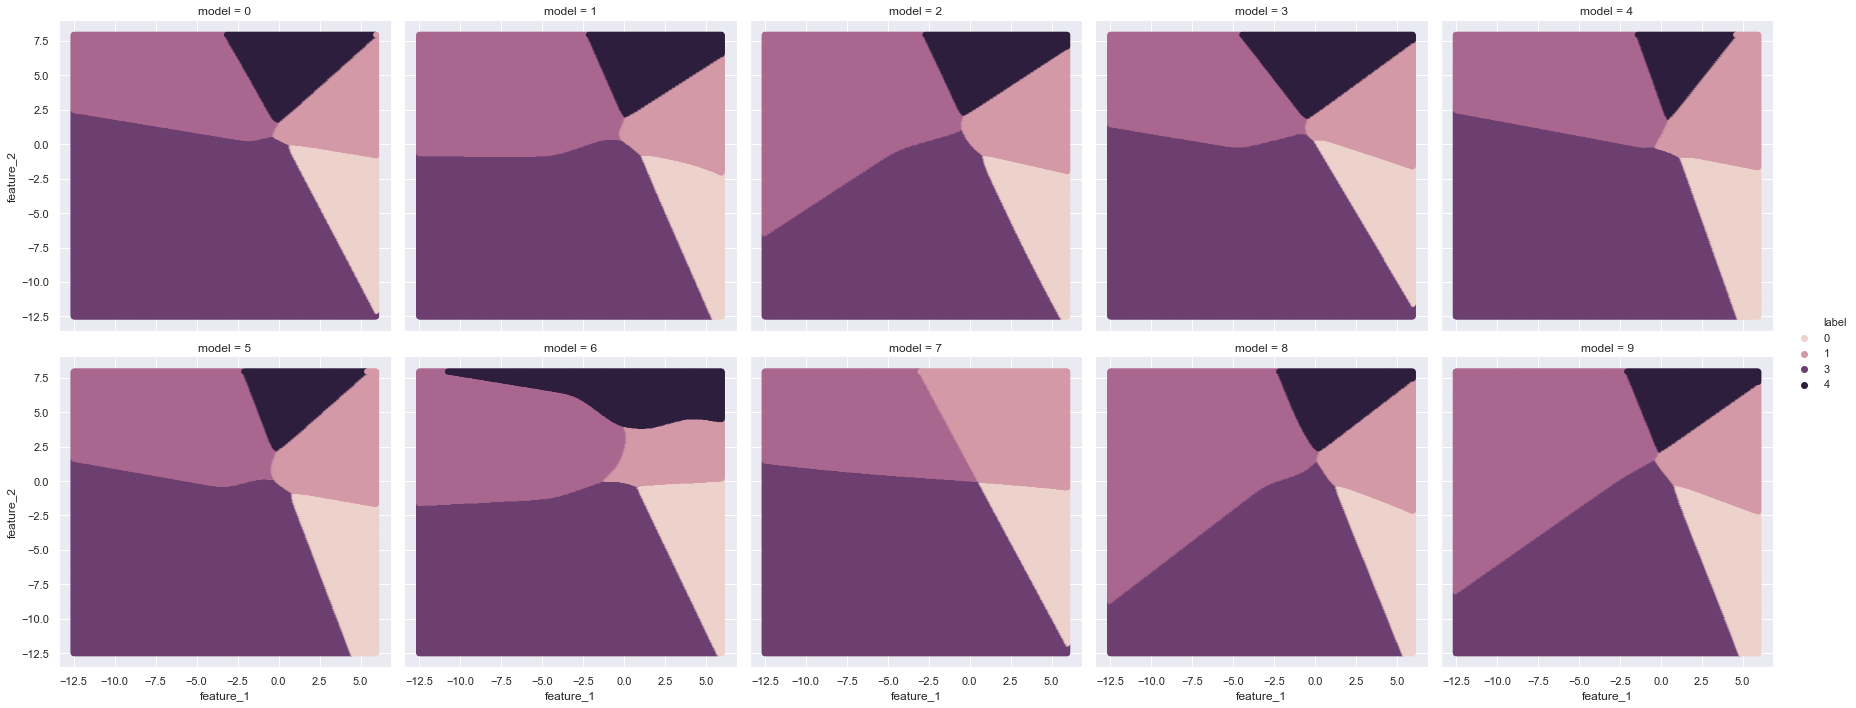

In [86]:
sns.relplot(x="feature_1", y="feature_2", hue="label", col="model", data=model_predictions, col_wrap=5, linewidth=0)

# FedAvg

In [272]:
n_clients = 10

client_idx = np.random.choice(n_samples, (n_clients, int(n_samples/ n_clients)), replace=False)

client_features = torch.tensor(X.detach().numpy()[client_idx]).float()
client_labels = torch.tensor(Y.detach().numpy()[client_idx])

## IID Client data in both $P_i(X)$ and $P_i(Y|X)$

In [273]:
df = pd.DataFrame(columns = ['client', 'feature_1', 'feature_2', 'label'])
df['client'] = [i for i in range(n_clients) for _ in range(int(n_samples/ n_clients))]
df['feature_1'] = client_features[:, :, 0].reshape(-1)
df['feature_2'] = client_features[:, :, 1].reshape(-1)
df['label'] = client_labels.reshape(-1)

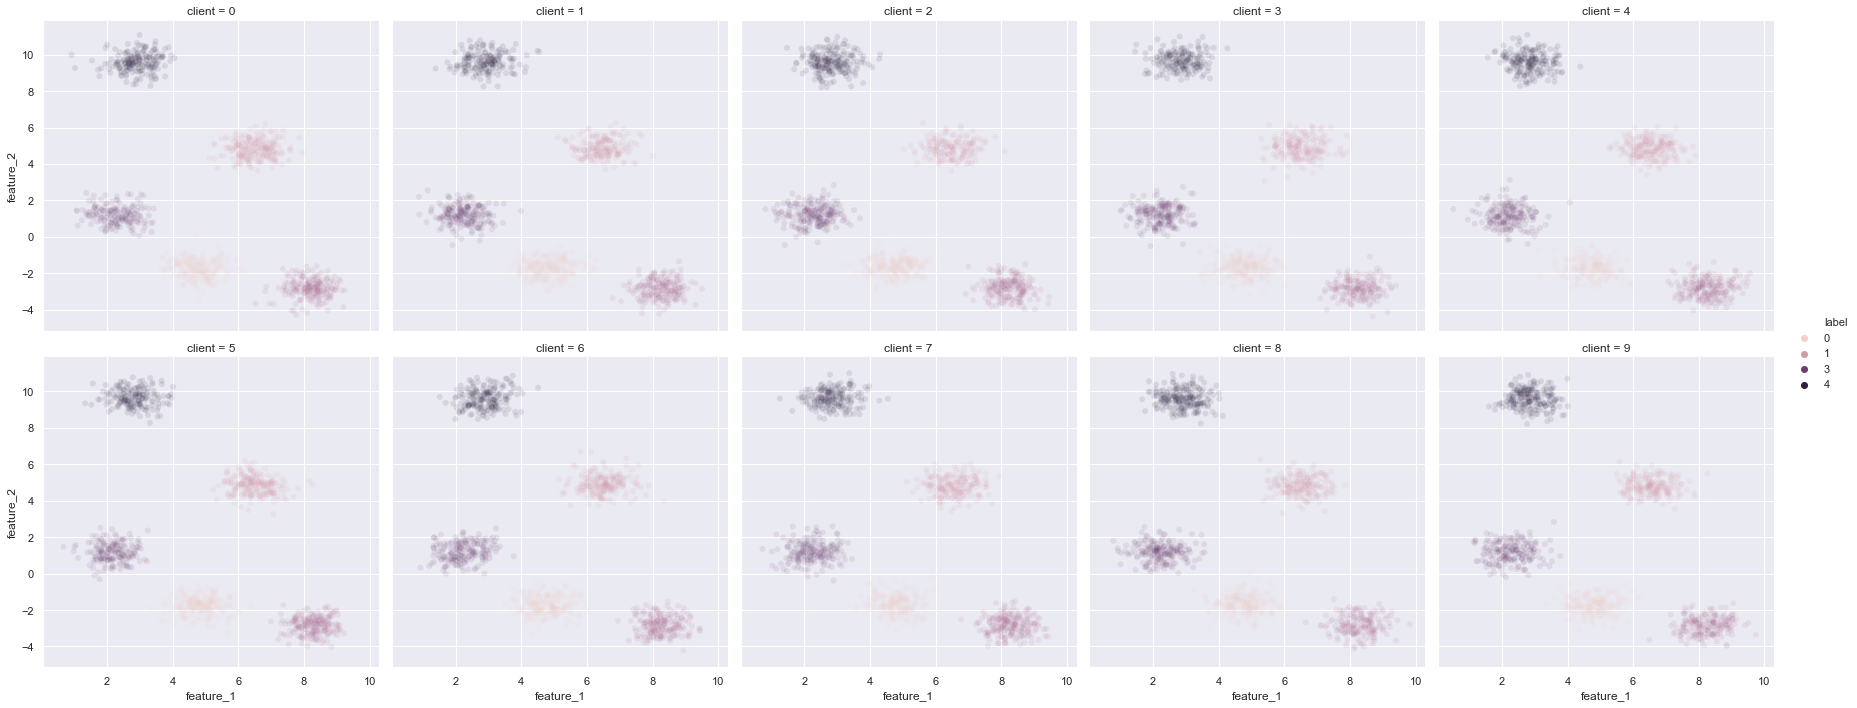

In [274]:
sns.relplot(x="feature_1", y="feature_2", hue="label", col="client", data=df, col_wrap=5, alpha=0.1, linewidth=0)
plt.show()

## Training

In [275]:
loss_fn = nn.NLLLoss()
batch_size = 1000
n_rounds = 20
n_steps = 40
lr = 0.01

In [276]:
zero_model = MLP().zero()
all_steps = [[[[] for _ in range(n_steps)] for _ in range(n_clients)] for _ in range(n_rounds)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]
server_model_params = [[] for _ in range(n_rounds+1)]

server_model = MLP()
for name, param in server_model.named_parameters():
    server_model_params[0].extend(list(param.view(-1).detach().numpy()))

for round in range(n_rounds):
    client_models = []
    for client in range(n_clients):
        client_model = copy(server_model)
        optimizer = optim.Adam(lr=lr, params=client_model.parameters())
        for step in range(n_steps):
            optimizer.zero_grad()
            # log params
            for name, param in client_model.named_parameters():
                all_steps[round][client][step].extend(list(param.view(-1).detach().numpy()))
                
            # step of sgd
            batch_idx = np.random.randint(0, int(n_samples / n_clients), batch_size)
            predict = client_model(client_features[client,batch_idx])
            loss = loss_fn(predict, client_labels[client, batch_idx])
            loss.backward()
            optimizer.step()
            
            # log metrics
            losses[client].append(loss.item())
            acc[client].append(sum(client_labels[client, batch_idx] == torch.argmax(predict, dim=1)).item())
        client_models.append(client_model)
    server_model = sum(client_models, zero_model) / n_clients
    for name, param in server_model.named_parameters():
        server_model_params[round+1].extend(list(param.view(-1).detach().numpy()))

## Training Visualization

In [277]:
step_matrix = torch.tensor(all_steps).reshape(-1, n_model_params)

In [278]:
server_models = torch.tensor(server_model_params).reshape(-1,n_model_params)

In [279]:
pca = PCA(n_components=2)

steps_pca = pca.fit_transform(step_matrix)
server_models_pca = pca.transform(server_models)

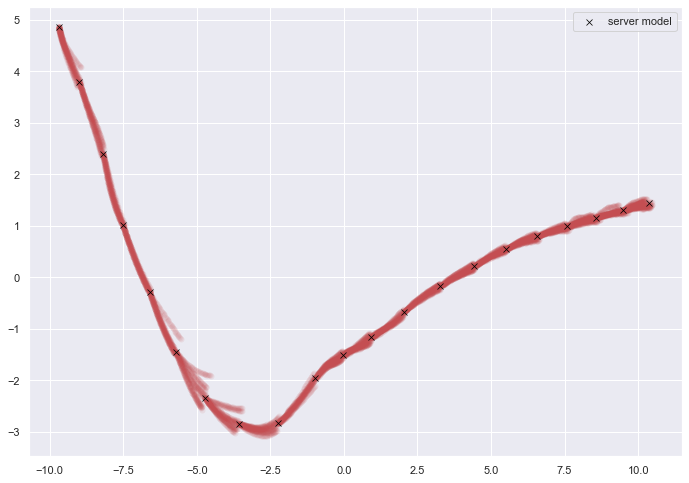

In [280]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(steps_pca[:,0],steps_pca[:, 1],color='r', linewidth=0, alpha=0.1)
sns.scatterplot(server_models_pca[:,0], server_models_pca[:,1], color='black', marker='x', label='server model')
plt.legend()
plt.show()

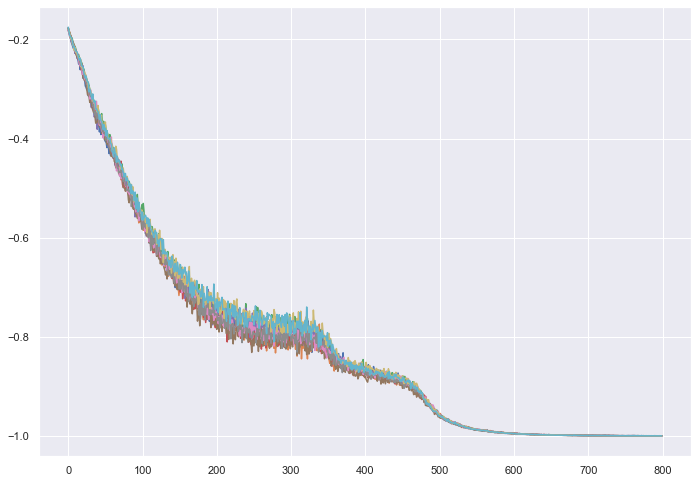

In [281]:
losses = np.array(losses)
for client in range(n_clients):
    plt.plot(losses[client])

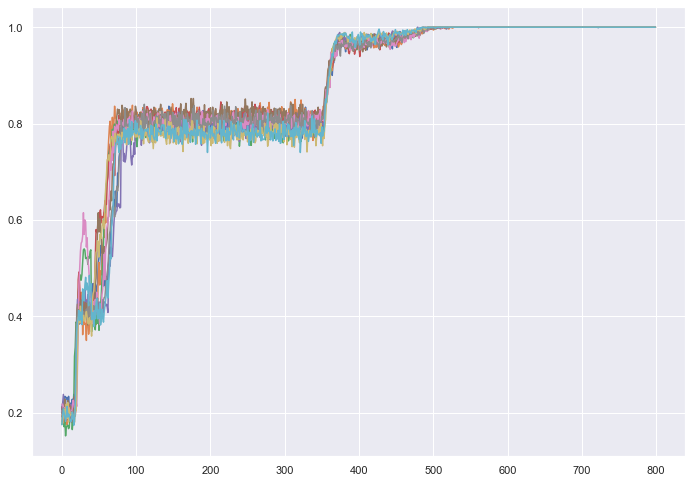

In [284]:
acc = np.array(acc) / batch_size * 100
for client in range(n_clients):
    plt.plot(acc[client])